# Basic Regression

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

## Installing Dependencies 

In [1]:
%pip install tensorflow tensorflow-macos tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.


## Importing Dependencies 

In [3]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from tensorflow import keras 
from tensorflow.keras import layers

np.set_printoptions(precision=3, suppress=True)

## Get The Data 

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

In [5]:
raw_dataset = pd.read_csv(
    url, 
    names=column_names, 
    na_values='?', 
    comment='\t', 
    sep=' ', 
    skipinitialspace=True
)

In [6]:
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [7]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data 

In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
dataset = dataset.dropna()

The "Origin" column is categorical, not numeric. So the next step is to one-hot encode the values

In [10]:
dataset['Origin'] = dataset['Origin'].map({ 1:'USA', 2:'Europe', 3:'Japan'})

In [11]:
dataset.head(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [12]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

In [13]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,False,False,True
1,15.0,8,350.0,165.0,3693.0,11.5,70,False,False,True
2,18.0,8,318.0,150.0,3436.0,11.0,70,False,False,True
3,16.0,8,304.0,150.0,3433.0,12.0,70,False,False,True
4,17.0,8,302.0,140.0,3449.0,10.5,70,False,False,True


## Split Data 

In [14]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Data Exploration 

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

Text(0.5, 1.0, 'MPG vs Displacement(Weight)')

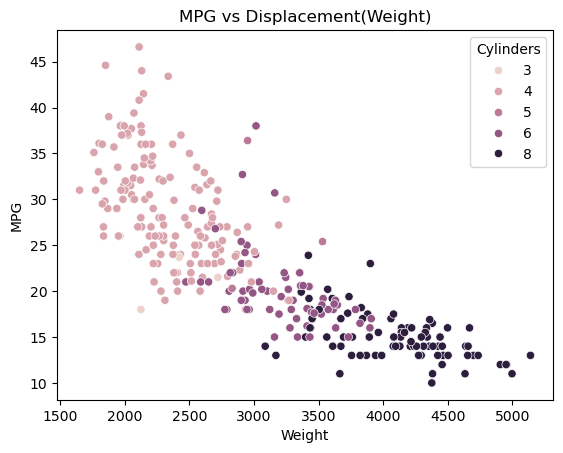

In [15]:
sns.scatterplot(x='Weight', y='MPG', hue='Cylinders', data=train_dataset)
plt.title('MPG vs Displacement(Weight)')

Now, let's look at what the above plot tells us about cars:

- Gas mileage (MPG) is important! You can see how MPG relates to other things like the car's weight, engine size, and number of cylinders. Lighter cars, smaller engines, and sometimes fewer cylinders often mean better gas mileage.
- Some things go together: You can see that cars with bigger engines are often heavier. This makes sense, right?
- Spotting the unusual: Sometimes a car might be really heavy but still get good gas mileage. That would stand out on the chart, and it might be something interesting to look into!

In [16]:
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


## Split features From Labels

Seperate the target value - the `label` from the features. The Label is the value you will train the model to predict 

In [17]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [18]:
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalize 

In [19]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


### Normalization Explained in Simplest Words

Imagine you're baking cookies using a recipe, but you have two measuring systems: one recipe card shows ingredients in grams, while another shows them in cups. If you mix these measurements without converting them to the same scale, you might end up with cookies that have way too much or too little of certain ingredients.
In machine learning, your "ingredients" are your features (the data you feed into the model). Just like in baking, these features often come in different "measuring systems" or scales. For example:

- Age might range from 0 to 100
- Income might range from 0 to millions
- Height might range from 150 to 200 centimeters

When your machine learning model processes these features, it multiplies each one by certain weights (like multiplying ingredients by a factor to make a bigger batch of cookies). If you don't normalize these features to a common scale first, here's what can happen:
The income feature, being in the millions, would have a huge impact on the model's calculations compared to age or height, simply because its numbers are bigger. This would be like accidentally using tablespoons instead of teaspoons in your recipe – the proportions would be all wrong!
By normalizing features (usually to a range between 0 and 1, or -1 and 1), you're essentially converting all your measurements to the same scale. It's like converting all recipe measurements to cups or grams so everything is consistent.
This makes training more stable because:

1. Your model can learn the true importance of each feature, rather than being overwhelmed by features that just happen to use bigger numbers
2. The calculations during training become more balanced and efficient
3. The model can find the optimal solution more easily

Think of it like trying to balance a seesaw. If one side has a massive weight and the other a tiny one, it's hard to find the right balance point. Normalization is like making sure both sides use weights in a similar range, making it much easier to balance.

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [20]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [21]:
normalizer.adapt(np.array(train_features))

2024-12-26 12:38:03.654092: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-26 12:38:03.654122: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-26 12:38:03.654131: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-26 12:38:03.654350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-26 12:38:03.654363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Calculate the mean and variance, and store them in the layer:

In [22]:
normalizer.mean.numpy()

array([[   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
           0.178,    0.197,    0.624]], dtype=float32)

When the layer is called, it returns the input data, with each feature independently normalized: 

In [23]:
first = np.array(train_features[:1], dtype=np.float32)

with np.printoptions(precision=2, suppress=True): 
    print('First Example', first)
    print()
    print('Normalized', normalizer(first).numpy())

First Example [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear Regression 

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear Regression with One Variable
Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'.


First, create a NumPy array made of the 'Horsepower' features. Then, instantiate the tf.keras.layers.Normalization and fit its state to the horsepower data:

In [35]:
horsepower = np.array(train_features['Horsepower'])
# horsepower = horsepower.reshape(-1, 1) 

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

/opt/anaconda3/envs/tensorflow-series/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Build the Keras Sequential Model 

In [36]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer, 
    layers.Dense(units=1)
])

In [37]:
horsepower_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [38]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


array([[ 0.097],
       [ 0.055],
       [-0.179],
       [ 0.136],
       [ 0.123],
       [ 0.048],
       [ 0.146],
       [ 0.123],
       [ 0.032],
       [ 0.055]], dtype=float32)

In [39]:
horsepower_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

In [40]:
%%time 
# Calculate validation results on 20% of the training data 
history = horsepower_model.fit(train_features['Horsepower'], train_labels, epochs=100, verbose=0, validation_split=0.2)

CPU times: user 6.41 s, sys: 2.17 s, total: 8.58 s
Wall time: 7.35 s


In [41]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.806284,4.171000,95
96,3.808285,4.197114,96
97,3.803417,4.178999,97
98,3.807345,4.168709,98
99,3.805010,4.196959,99


In [42]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

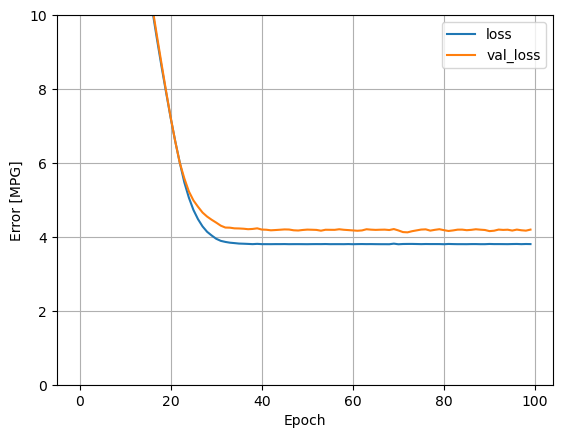

In [44]:
plot_loss(history)

### Collect Test Results 

In [45]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

### Prediction For Single Variable Regression

In [51]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [47]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

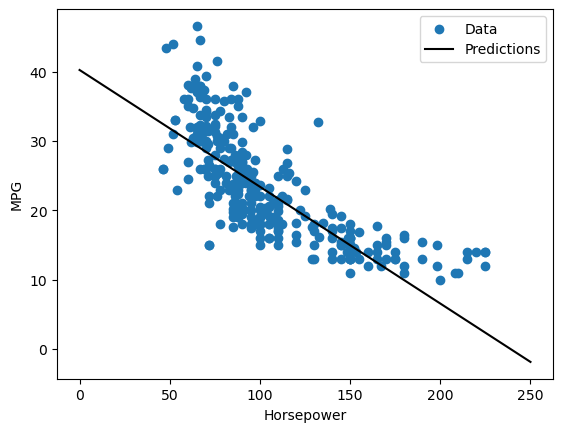

In [48]:
plot_horsepower(x, y)

## Linear Regression with Multiple Inputs

In [49]:
linear_model = tf.keras.Sequential([
    normalizer, 
    layers.Dense(units=1)
])

In [52]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


array([[ 1.361],
       [ 0.447],
       [-2.54 ],
       [-0.169],
       [ 3.559],
       [-0.767],
       [ 3.864],
       [ 0.219],
       [ 0.083],
       [ 4.983]], dtype=float32)

In [55]:
linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

In [56]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 6.86 s, sys: 2.45 s, total: 9.32 s
Wall time: 8.05 s


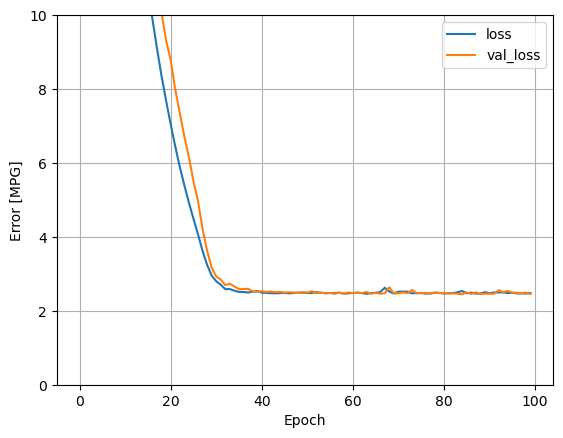

In [57]:
plot_loss(history)

In [58]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [59]:
test_results

{'horsepower_model': 3.6447625160217285, 'linear_model': 2.484774112701416}

Both models will use the same training procedure, so the compile method is included in the build_and_compile_model function below.

In [61]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

## Regression using a DNN and a single Input 

Create a DNN model with only 'Horsepower' as input and horsepower_normalizer as the normalization layer:

In [62]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [63]:
dnn_horsepower_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [64]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 9.51 s, sys: 3.33 s, total: 12.8 s
Wall time: 11.4 s


In [65]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


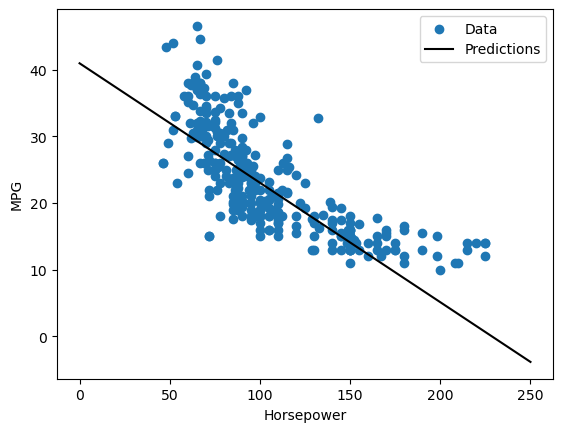

In [66]:
plot_horsepower(x, y)

In [67]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

## Regression using a DNN and a Multipe Inputs

In [68]:
dnn_model = build_and_compile_model(normalizer)

In [69]:
dnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [70]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 9.56 s, sys: 3.29 s, total: 12.8 s
Wall time: 10.5 s


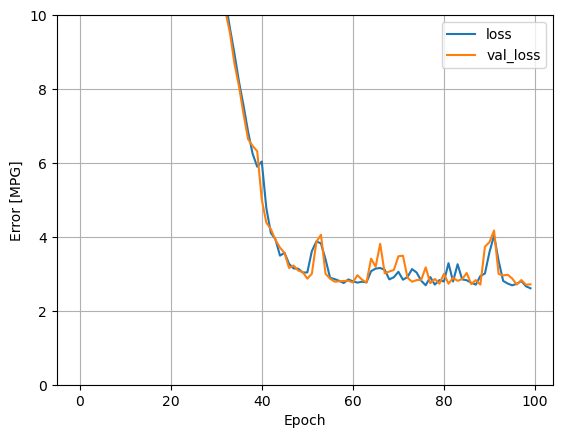

In [71]:
plot_loss(history)

In [74]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance 

In [75]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.644763
linear_model,2.484774
dnn_horsepower_model,3.755924
dnn_model,2.466361


### Make predictions with dnn_model

In [80]:
test_predictions = dnn_model.predict(test_features)
test_predictions = test_predictions.flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [81]:
test_predictions

array([10.143,  5.382,  5.981, 26.265, 21.031,  8.016, 10.764,  6.925,
       18.781, 29.995, 25.656, 26.864, 13.231, 25.837, 11.369, 13.77 ,
       14.44 , 10.928, 20.114,  9.538,  8.067, 26.876, 22.209, 23.448,
       30.102, 25.099, 16.857, 26.532, 18.797, 20.468, 29.625, 22.817,
       20.622, 23.814, 27.37 , 14.884, 21.647, 28.867, 30.485, 18.909,
       31.233, 30.213, 14.75 , 31.083, 31.621, 32.879, 22.774, 23.817,
       20.808, 28.564, 29.263, 23.676, 31.715, 17.009, 16.224, 16.453,
       32.317, 33.572, 22.664, 25.877, 31.798, 31.835, 27.779, 27.227,
       29.75 , 35.809, 34.356, 32.063, 31.918, 25.483, 22.685, 19.537,
       28.452, 29.635, 33.215, 33.29 , 35.125, 28.775], dtype=float32)

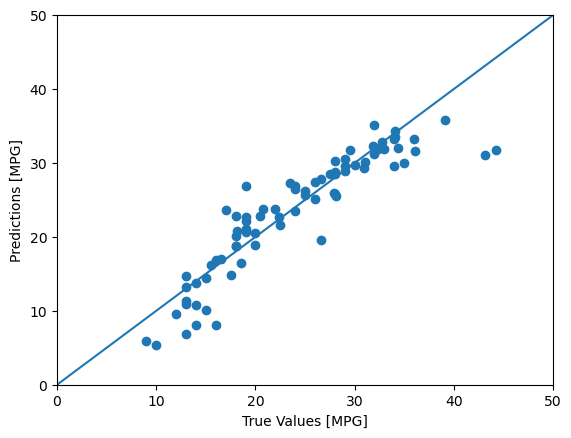

In [87]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

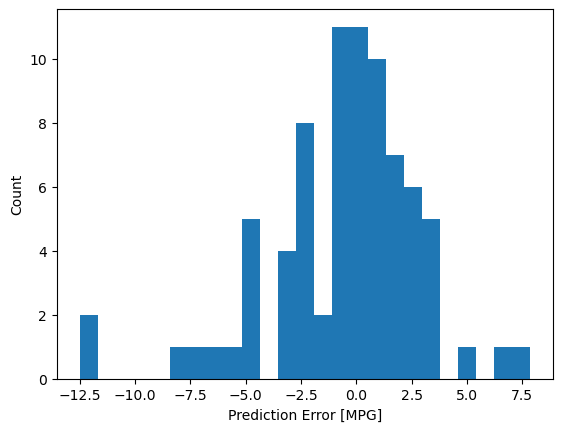

In [88]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')